

# Link Prediction and Feedback Loops


In this set of lectures, we'll study an important task in network data science: **link prediction**. [Link prediction was popularized as a task in network analysis and machine learning by @liben2003link]{.aside} The link prediction task is to, given a current network and possibly some additional data, predict future edges. This task has many applications:

- In scientific tasks, we may not be able to collect data on all the edges that we are interested in. If we can develop a model that allows us to predict missing edges, we might be able to learn something about the overall network structure even from partial data.
- Many online recommendation systems are in fact link prediction algorithms. When Facebook recommends a friend to you, for example, this is usually done by training an algorithm that predicts edges in a social network based on attributes, shared friends, etc.

In the first part of these lecture notes, we'll implement a simple link prediction model. In the second part, we'll do a simple simulation to learn about how link prediction models can change the structure of social networks.

[We mostly won't write our own code in these notes: a lot of the code involves manipulation of data frames or machine learning workflows which we don't assume that you've learned yet. The [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) by Jake VanderPlas is an outstanding resource for learning these tools.]{.aside}


## Implementing Link Prediction


### Data Acquisition and Splitting

Our data set for this experiment is the network of social interactions in a French high school [@fournet2014contact], which we also studied in a [previous chapter on modularity maximization](13-modularity-maximization.qmd).

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

from itertools import product

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

::: {.column-margin}

This hidden code cell imports several packages that we'll need for the experiments shown in this chapter.

:::


Let's go ahead and acquire the data. We'll also do a bit of cleaning.

In [2]:
url = "https://raw.githubusercontent.com/network-science-notes/network-science-notes.github.io/refs/heads/main/data/contact-high-school.csv"

contact = pd.read_csv(url, sep = "\t", names = ["time", "source", "target", "class1", "class2"])[["source", "target"]]

# remove a small number of self-loops
contact = contact[contact["source"] < contact["target"]]

### Train-Test Split

Now we'll perform a split into training and testing data. The idea is that we will use the training data for tuning our model, while we'll use the testing data for evaluating the model. We won't actually compute the predictive performance of the model on the testing data until we are done with all of our training.

In [3]:
# number of interactions to include in training data
m_train = 30000

train = contact.loc[0:m_train,:].copy()
test = contact.loc[m_train:,:].copy()

It can be very difficult to make useful predictions about whether or not an edge emerges if we don't know anything already about the nodes. For this reason, we are going to restrict the test set so that all nodes in the test set are also seen at least once in the training set.

In [16]:
# we are only going to attempt to make predictions about the existence of an
# edge between two nodes in cases when both nodes had at least one edge
# in the training data.

train_nodes = np.unique(np.concatenate([train.source, train.target]))
test["found_source"] = test.source.map(lambda x: x in train_nodes)
test["found_target"] = test.target.map(lambda x: x in train_nodes)
test = test[test.found_source & test.found_target]

Finally, rather than try to predict the *number* of interactions between two agents, we are instead just going to focus on whether or not there was at least one. To do this, we'll create new versions of our data frames in which each pair appears exactly once.

In [5]:
train   = train.groupby(["source", "target"]).count().reset_index()
test    = test.groupby(["source", "target"]).count().reset_index()

Our final data sets

In [6]:
print(f"{train.shape[0]} edges in training data.")
print(f"{test.shape[0]} edges in testing data.")

1778 edges in training data.
1024 edges in testing data.


Although we've been working with these data sets as data frames, they do both define networks: a training network and a testing network.

In [7]:
G_train = nx.from_pandas_edgelist(train)

Here's a picture of the resulting network, with communities found via the Louvain algorithm for approximate modularity maximization: [We could also study the "communities" defined by the true labels in the data, although we won't pursue that here.]{.aside}

In [8]:
def louvain_communities(G, return_partition = False):

    # run Louvain
    comms  = nx.community.louvain_communities(G, resolution = 1)

    # process the labels
    labels = [l for i in G.nodes for l in range(len(comms)) if i in comms[l]]
    node_list = list(G.nodes)
    comm_dict = {node_list[i] : labels[i] for i in range(len(node_list))}

    if return_partition:
        return comm_dict, comms

    return comm_dict

def louvain_plot(G, ax, clusters = None, pos = None, **kwargs):

    node_kwargs = {"node_size" : 50, "edgecolors" : 'black'}

    if not clusters:
        clusters = louvain_communities(G)

    # draw the result
    if not pos:
        pos = nx.fruchterman_reingold_layout(G)
    labels = [clusters[i] for i in G.nodes]

    if clusters is not None:
        num_clusters = np.unique(list(clusters.values())).shape[0]
        cluster_to_color = [plt.cm.Set3(i) for i in range(num_clusters)]
        node_kwargs["node_color"] = [cluster_to_color[clusters[i]] for i in G.nodes()]
    if pos is None:
        pos = nx.spring_layout(G)

    edge_kwargs = {"edge_color" : "gray", "alpha" : 0.3}
    nx.draw_networkx_edges(G, pos, ax = ax, **edge_kwargs)
    nx.draw_networkx_nodes(G, pos, ax = ax, **node_kwargs)
    off = ax.axis("off")

::: {.column-margin}

This hidden code cell implements the code for the `louvain_plot` function used below.

:::

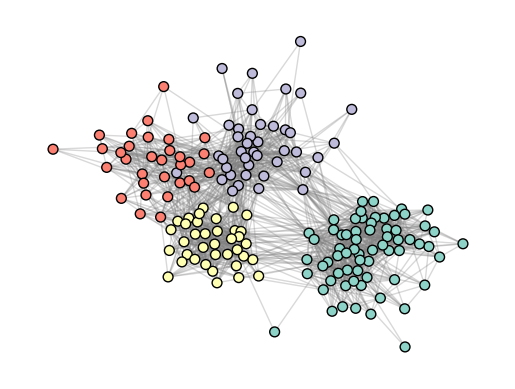

In [18]:
fig, ax = plt.subplots(1, 1)
louvain_plot(G_train, ax = ax)

### Data Preparation

There are two important steps of data preparation that we need to implement.

In the first step, we need to add *negative examples* to our training data. A negative example is simply a pair of nodes that *don't* have an edge between them. We want our algorithm to be able to tell the difference between interactions which occurred and *interactions which did not occur*. To do this, we need to be able to show our model some potential interactions which did not actually occur in the data. We'll therefore add *negative examples*: pairs of nodes which did *not* interact.

In the second step, we are going to engineer *features* for each pair of nodes. This is an extremely flexible step, which can make use of many different kinds of techniques. We're going to use some of the tools that we developed in this course as features.

#### Negative Examples

Let's go ahead and implement negative examples.

In [10]:
def add_negative_examples(df):

    # new copy of input data frame, with a new column
    df_ = df.copy()
    df_["link"] = 1

    # data frame with all node pairs
    node_list = np.unique(np.append(df_["source"], df_["target"]))
    negative = pd.DataFrame(product(node_list, node_list), columns = ["source", "target"])
    negative = negative[negative["source"] < negative["target"]]

    # add real data and make a column distinguishing positive from negative examples
    merged_df = pd.merge(negative, df_, on = ["source", "target"], how = "left")
    merged_df["link"] = merged_df["link"] == 1

    return merged_df

::: {.column-margin}

The function in the hidden code block creates a new data frame that contains *all* pairs of nodes in the graph. A new `link` column distinguishes which pairs of nodes actually have edges.

:::


Here's how this looks:

In [11]:
train = add_negative_examples(train)
train.sort_values("link", ascending = False)

,source,target,link
1438,610,692,True
9239,687,1662,True
9237,687,1658,True
5437,648,666,True
5434,648,663,True
...,...,...,...
5510,648,867,False
5511,648,868,False
5512,648,869,False
5513,648,871,False


After this step, the training data actually contains very few positive examples:

In [12]:
train["link"].mean()

np.float64(0.11414997431946584)

We're hoping that our model is able to learn some information about what makes these 11% of node pairs more likely to have edges than the other 89%.

#### Feature Engineering

We now need to create *features* for our model to use to make predictions. We can think of features as "things we think should be useful for predicting the presence of an edge." This is where we need to bring in some theory: what *does* make two nodes more likely to have an edge between them? There are a lot of possibilities here, not all of which will necessarily work. Here, we're going to predict whether or not there is an edge between nodes $i$ and $j$ using the following features:

- The class of the source node $i$, $g_i$.
- The class of the target node $j$, $g_j$.
- The number of interactions that the source node $i$ has had in the training data (i.e. the degree of $i$), $k_i$.
- The number of interactions that the target node $j$ has had in the training data (i.e. the degree of $j$), $k_j$.
- The number of common neighbors of $i$ and $j$ in the training data, which we'll call $c_{ij}$. This idea is related to *triadic closure*, which we studied earlier in these notes -- if the two nodes share a lot of common neighbors, then a link between them would result in more closed triangles.

The following, rather complicated function creates a data frame containing all of these features. Because we're adding columns to `pandas` data frames, we usually `apply` functions in order to skip `for`-loops and their ilk.

In [13]:
def compute_features(df, G = None, comm_dict = None):

    # make the graph if it's not supplied externally
    if not G:
        edges = df[df["link"]]
        G = nx.from_pandas_edgelist(edges)

    # make the community labels if not supplied externally.
    if not comm_dict:
        comm_dict = louvain_communities(G)

    # columns for degree of each node in G
    df["deg_source"] = df.source.apply(lambda x: G.degree(x))
    df["deg_target"] = df.target.apply(lambda x: G.degree(x))


    # communities of each node in G
    comm_source = df.source.apply(lambda x: comm_dict[x])
    comm_target = df.target.apply(lambda x: comm_dict[x])

    # number of common neighbors -- networkx has a handy function that does
    # this for us! Just gotta get a little fancy with the anonymous function
    # calls.
    df["common_neighbors"] = df[["source", "target"]].apply(lambda pair: len(list(nx.common_neighbors(G, pair.source, pair.target))), axis = 1)

    # add dummy columns for the combination of each community.
    combined_comm = "C" + comm_source.map(str) + comm_target.map(str)
    df = pd.concat([df, pd.get_dummies(combined_comm)], axis = 1)

    return df

Let's apply this function to our training data. To do so, we need to supply a community partition:

In [14]:
comm_dict_train = louvain_communities(G_train)
train = compute_features(train, G_train, comm_dict_train)

Time to inspect the results!

In [15]:
train

,source,target,link,deg_source,deg_target,common_neighbors,C00,C01,C02,C03,...,C12,C13,C20,C21,C22,C23,C30,C31,C32,C33
0,600,601,False,22,24,10,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,600,602,False,22,10,0,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,600,603,False,22,16,0,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,600,605,False,22,17,1,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,600,606,False,22,17,1,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15571,1678,1686,False,36,28,20,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
15572,1678,1856,False,36,14,9,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
15573,1679,1686,True,13,28,8,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
15574,1679,1856,False,13,14,5,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


We can see that we have a lot more columns that we started with. The `C` columns hold information about the communities of the nodes involved. For example, `C13` means that the `source` node is in community `1` and the `target` node is in community `3`. In each row, only one of these columns can have value `True`.  


::: {.callout-note}

Brainstorm! What are some other examples of features that you would compute between a pair of nodes in order to assess whether or not they are likely to have an edge between them? What if you had access to additional metadata about the nodes? What if the network was directed?

:::


### Model Training and Interpretation


We have now assembled a number of features for our data. How are we going to turn these features into predictions? Our overall strategy will be to use a linear model. A linear model assigns a score $s_{ij}$ to each pair of nodes $i$ and $j$, which is computed using the features we have constructed. Our score function for this set of features will be:

$$
\begin{aligned}
s_{ij} = \beta_0 + \beta_1 k_{i} + \beta_2 k_{j}  + \beta_3 \text{(common neighbors)}_{ij} + \gamma_{C_i,C_j}\;,
\end{aligned}
$$

where $C_i$ and $C_j$ are the communities of nodes $i$ and $j$, respectively. The $\gamma$ terms are coefficients that are specific to each pair of communities. The idea is that we'll compute scores for all possible pairs of nodes, and predict that the pairs with the highest scores are the ones that are most likely to have edges form between them.

In order to do this, we need to figure out how to learn the parameters $\beta_0,\; \beta_1,\; \beta_2,\; \beta_3,\; \gamma$ from data. We'll do this using logistic regression. To do this, we extract a matrix `X_train` containing only the feature columns, and a vector `y_train` containing the target `link` variable.

In [19]:
feature_cols = [col for col in train.columns if col not in ["source", "target", "link"]]

X_train = train[feature_cols]
y_train = train["link"]

Now we can fit the model:

In [20]:
model   = LogisticRegression(solver = "liblinear")
fit     = model.fit(X_train, y_train)

What did our model learn about the features? Which of these features help predict whether an edge is going to be observed between two nodes? Let's take a look at the coefficients:


In [21]:
pd.DataFrame({
    "feature" : model.feature_names_in_,
    "coef" : model.coef_[0]
})

,feature,coef
0,deg_source,0.017152
1,deg_target,0.016098
2,common_neighbors,0.272434
3,C00,0.656338
4,C01,-0.478191
5,C02,-0.114537
6,C03,-1.084058
7,C10,0.271522
8,C11,0.928956
9,C12,-0.087188


*Positive* coefficients indicate that larger values of the feature make edges more likely, while negative coefficients indicate the opposite. There's a lot to take in, but let's focus on some of the big picture highlights:

First, the first three features all have positive coefficients. This indicates that an edge is more likely between two nodes when:

- Each node has higher degree.
- The two nodes share many common neighbors.

It's interesting to note that the coefficient of the number of common neighbors is *so* much higher than the coefficients for the individual node degrees. According to our model, adding 5 neighbors to each node in a pair has less of an impact on the likelihood of an edge than adding a single neighbor that is *shared* by both of them.

Second, while the community features can be a little hard to interpret, the thing that sticks out is that the features with the most positive coefficients are the ones in which both nodes belong to the same community. This tells us that edges are more likely to exist between nodes in the same community, which makes sense -- this is pretty much guaranteed based on how modularity maximization defines communities in the first place.

### Model Evaluation

It's all well and good to fit our model on training data and interpret the coefficient, but this doesn't necessarily tell us anything about the ability of our model to make *predictions* about the future. To do this, we need to look at our test data. In this case, it's important that we pass the test data through the same preprocessing as we did before, adding negative examples and feature columns. Very importantly, we pass the graph `G_train` and the community labels `comm_dict_train` as an argument to `compute_features` in order to ensure that things like degree and community structure are calculated using only training data, not testing data. Using testing data to construct the features would be cheating!

In [22]:
test = add_negative_examples(test)
test = compute_features(test, G_train, comm_dict_train)

X_test = test[feature_cols]
y_test = test["link"]

We can now get the model's predicted probability of edge presence for each pair of nodes. [The predicted probability of an edge between nodes $i$ and $j$ is $\sigma(s_{ij})$, where $s_{ij}$ is the score for the pair $(i,j)$ and $\sigma(x) = \frac{1}{1 + e^{-x}}$ is the logistic sigmoid function.]{.aside}

In [23]:
y_pred = model.predict_proba(X_test)[::,1]

We can interpret these predictions like this:

In [24]:
i = 1932
f"Our model predicts that the probability of a new edge between nodes {test['source'][i]} and {test['target'][i]} is approximately {np.round(y_pred[i], 2)}."

'Our model predicts that the probability of a new edge between nodes 615 and 682 is approximately 0.02.'

How accurate are these predictions? We can use the `score` method of the model to compute the accuracy of the model on the test data on the prediction task. [By default, the model is predicting the presence of an edge iff $\sigma(s_{ij}) > 0.5$. ]{.aside}

In [25]:
model.score(X_test, y_test)

0.9143348795451145

Over all, our model achieves an accuracy of roughly 90% in the task of predicting the presence of edges in the test data. Is this a good result? Not especially, actually. The reason is that the test set contains very few positive examples:

In [26]:
test["link"].mean()

np.float64(0.07661229986532994)

So, an algorithm that predicted that no edges would form between any pair of nodes would have an accuracy of around 92%. Our model isn't any better than this!

This doesn't mean that our model is poor, just that accuracy is not the right way to assess it. A more sophisticated way to assess a binary classification model is to compute the area under the receiver operating characteristic curve (often just called the "area under the curve" or "AUC" for short). The AUC measures the tradeoff between false positive and true positive rates when varying the threshold score required to predict the presence of an edge.

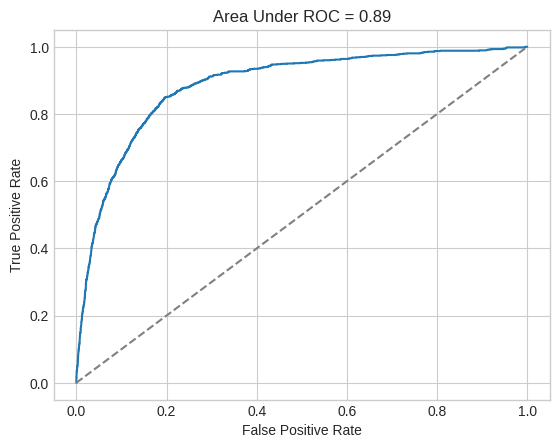

In [27]:

fig, ax = plt.subplots(1, 1)

auc = metrics.roc_auc_score(y_test, y_pred)
false_positive_rate, false_negative_rate, _ = metrics.roc_curve(y_test,  y_pred)

ax.plot(false_positive_rate,false_negative_rate)
ax.set(title = f"Area Under ROC = {np.round(auc, 2)}",
       ylabel = "True Positive Rate",
       xlabel = "False Positive Rate")

ax.plot([0,1], [0,1], color = "grey", linestyle = "--")

An AUC of 50% corresponds to a model that has failed to learn anything about the data, while an AUC of 100% corresponds to perfect prediction. The AUC we've realized here isn't perfect, but it shows that we are able to predict the formation of new edges much more accurately than would be possible by random chance.






## Impact of Algorithmic Recommendations on Social Networks

Link prediction algorithms are often used by apps and platforms to make recommendations. When Twitter suggests a new profile for you to follow, for example, they often do this on the basis of a link prediction algorithm: users like you have often followed profiles like that one in the past, and so they think that you might like to follow it now. From the perspective of the company making these recommendations, the overall purpose is to increase "engagement" on their platform. More engagement leads to more time spent scrolling, which leads to more time watching money-making ads.

But what happens to the structure of social networks under the influence of link-prediction algorithms? The details of course here depend on the algorithm, but let's use a version of the one we used in the previous section. We're going to wrap the whole thing up in a Python class. The idea is that we are going to repeatedly:

1. Train a link prediction model on the current state of the network.
2. Update the network by allowing some edges to decay and replacing them with new edges that the model predicts are likely to form.


In [28]:
class LinkPredictionSimulator:

    def __init__(self, edge_df, **kwargs):

        self.edge_df = edge_df.copy()
        self.G = nx.from_pandas_edgelist(self.edge_df)
        self.kwargs = kwargs
        self.node_list = list(self.G.nodes)
        self.comm_dict, self.comms = louvain_communities(self.G, True)

    #

    def prep_data(self):
        """
        add negative examples and compute features on the current data frame of edges, using stored community labels for community features.
        """
        self.train_df = add_negative_examples(self.edge_df)
        self.train_df = compute_features(self.train_df, comm_dict = self.comm_dict, **self.kwargs)

        # store the names of the feature columns for later
        self.feature_cols = [col for col in self.train_df.columns if col not in ["source", "target", "link"]]

    def train_model(self):
        """
        Train a logistic classifier on the current data after features have been added.
        """
        X = self.train_df[self.feature_cols]
        y = self.train_df["link"]

        self.model = LogisticRegression(solver = "liblinear")
        self.model.fit(X, y)

    def get_predicted_edges(self, m_replace):
        """
        Return a data frame containing the m_replace most likely new edges that are not already present in the graph.
        """

        # data frame of candidate pairs
        pairs = pd.DataFrame(product(self.node_list, self.node_list), columns = ["source", "target"])
        pairs = pairs[pairs["source"] < pairs["target"]]

        # add features to the candidate pairs
        pairs = compute_features(pairs, comm_dict = self.comm_dict, G = self.G, **self.kwargs)

        # add the model predictions
        pairs["edge_score"] = self.model.predict_proba(pairs[self.feature_cols])[:,1]

        # remove pairs that already present in the graph
        pairs = pd.merge(pairs, self.edge_df, on = ["source", "target"], indicator = True, how = "outer")
        pairs = pairs[pairs._merge == "left_only"]

        # get the m_replace pairs with the highest predicted probability
        # and return them
        pairs = pairs.sort_values("edge_score", ascending = False).head(m_replace)
        return pairs[["source", "target"]]

    def update_edges(self, m_replace):
        """
        removes m_replace edges from the current graph, and replaces them with m_replace predicted edges from get_predicted_edges.
        """

        # remove m_replace random edges
        self.edge_df = self.edge_df.sample(len(self.edge_df) - m_replace)

        # add m_replace recommended edges
        new_edges = self.get_predicted_edges(m_replace)
        self.edge_df = pd.concat([self.edge_df, new_edges])


    def step(self, m_replace = 1, train = True):
        """
        main simulation function. In each step, we do the data preparation steps, train the model, and update the graph.
        """
        self.prep_data()
        self.train_model()
        self.update_edges(m_replace)
        self.G = nx.from_pandas_edgelist(self.edge_df)
        self.G.add_nodes_from(self.node_list)

    #

    def degree_gini(self):
        """
        The Gini coefficient is a measure of inequality. We are going to use it to measure the extent of inequality in the degree distribution. Higher Gini = more inequality in the degree distribution.

        code from https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy
        """

        degs = np.array([self.G.degree[i] for i in self.G.nodes])
        mad = np.abs(np.subtract.outer(degs, degs)).mean()
        rmad = mad/np.mean(degs)
        g = 0.5 * rmad
        return g

    def modularity(self):
        """
        modularity of the stored partition
        """
        return nx.algorithms.community.modularity(self.G, self.comms)

::: {.column-margin}

This hidden code cell defines a class that simulates the impact of a link prediction algorithm on a social network. The class has methods for training a link prediction model, updating the network, and measuring the modularity and degree Gini coefficient of the network.

:::

Let's now instantiate the simulator, using the entire `contact` network.

In [29]:
edges = contact.groupby(["source", "target"]).count().reset_index()
LPS = LinkPredictionSimulator(edges)

Now we're going to conduct our simulation. Along the way, we've set up code so that we can see the graph (and its community partition) before and after the simulation. While we do the simulation, we'll collect the modularity and degree Gini coefficient, which measures how unequal the degrees in the graph are.

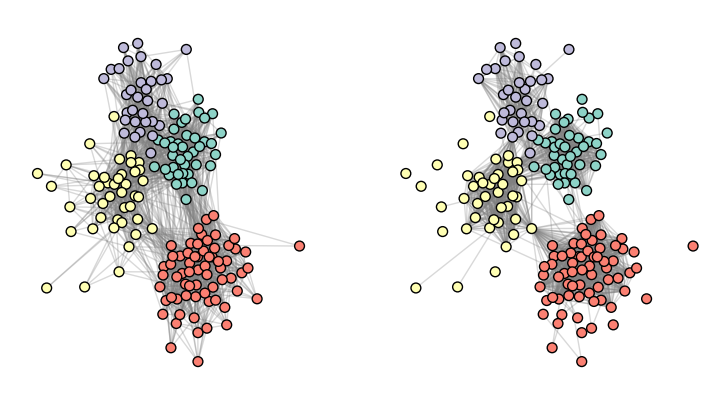

In [30]:

# set up the plot
fig, axarr = plt.subplots(1, 2, figsize = (9, 5))
pos = nx.fruchterman_reingold_layout(LPS.G)

# initial state of the graph
louvain_plot(LPS.G, clusters = LPS.comm_dict, ax = axarr[0], pos = pos)

# initialize tracking the modularity and gini coefficients
Q    = []
gini = []

# main loop
LPS.step(0, train = True)
for i in range(50):
    LPS.step(100, train = True)
    Q.append(LPS.modularity())
    gini.append(LPS.degree_gini())

# visualize final state of the graph
louvain_plot(LPS.G, clusters = LPS.comm_dict, ax = axarr[1], pos = pos)

Here's what happened to the modularity and the degree Gini inequality as the simulation progressed:

[Text(0.5, 0, 'Timestep'), Text(0, 0.5, 'Value')]

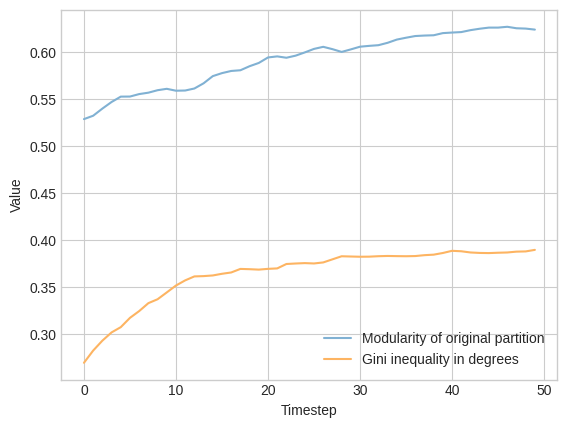

In [31]:

fig, ax = plt.subplots(1, 1)

ax.plot(Q, label = "Modularity of original partition", color = plt.cm.Set3(4))
ax.plot(gini, label = "Gini inequality in degrees", color = plt.cm.Set3(5))
ax.legend()

ax.set(xlabel = "Timestep", ylabel = "Value")

***In this specific, simple model***, algorithmic recommendations caused the network to change considerably in its structure.

- There are more closed-off, insular communities as indicated by the higher modularity score.
- There is increased inequality of influence, at least as measured by the node degree.

It's important to note that these results have multiple interpretations. Tighter communities could just mean that the platform is better at helping people connect to their interests, and in some cases this might be harmless. On the other hand, such tight communities also smack of echo chambers; in cases related to opinion exchange or debate, it might be difficult for people to actually encounter contrary opinions in this setting. Equality of influence might seem like a good thing, but could also indicate that people with extreme or repugnant viewpoints have become mainstreamed. So, while it's clear that the algorithm has significantly changed the overall structure of the social network, it's important to think critically in context in order to understand whether that's truly a bad thing or not.

Overall, our findings suggest that the influence of automated recommendation algorithms have the possibility to change the overall shape of social networks in ways that may be harmful or helpful. For some perspectives on how algorithmic influence shapes collective behavior, and what this might imply, see @bak2021stewardship.  

## References